# **STINTSY Major Course Output**

### S11 - BOOMBAYOT 
- Canayon Jr., Roger
- Pangan, Yumi Ann
- Vasquez, Ryan Clemence

## **Section 1. Introduction to the problem/task and dataset**
Each group should select one real-world dataset from the list of datasets provided for the
project. Each dataset is accompanied with a description file, which also contains detailed
description of each feature.
The target task (i.e., classification or regression) should be properly stated as wel

## **Section 2. Description of the dataset**
In this section of the notebook, you must fulfill the following:
- State a brief description of the dataset.
- Provide a description of the collection process executed to build the dataset. Discuss the
implications of the data collection method on the generated conclusions and insights.
Note that you may need to look at relevant sources related to the dataset to acquire
necessary information for this part of the project.
- Describe the structure of the dataset file.
    - What does each row and column represent?
    - How many instances are there in the dataset?
    - How many features are there in the dataset?
    - If the dataset is composed of different files that you will combine in the succeeding
steps, describe the structure and the contents of each file.
- Discuss the features in each dataset file. What does each feature represent? All features,
even those which are not used for the study, should be described to the reader. The
purpose of each feature in the dataset should be clear to the reader of the notebook
without having to go through an external link.

## **Section 3. List of requirements**
List all the Python libraries and modules that you used.


In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as mplstyle

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('sports.csv')

## **Section 4. Data preprocessing and cleaning**

In [3]:
df.head()

,uuid,current_minute,home_score,away_score,home_yellow_cards,away_yellow_cards,home_red_cards,away_red_cards,home_attacks,away_attacks,...,away_dangerous_attacks,home_corners,away_corners,home_off_target,away_off_target,home_on_target,away_on_target,home_possession,away_possession,final_delta
0,2f9dd904-8d9d-4aa0-a9d9-4e0f3e50d742,94,1,2,0,0,0,0,39,45,...,26,4,1,4,0,4,6,48,52,1
1,869c1420-9153-4d73-8d79-5db31a8a80a4,91,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,50,50,1
2,549e25a3-4c93-459d-b115-fb303273c78a,3,0,0,0,0,0,0,3,1,...,0,0,0,0,0,0,0,62,38,4
3,287b4be5-9163-4e2e-895d-d11052a97410,17,0,0,1,0,0,0,41,46,...,25,1,0,0,2,0,0,55,45,2
4,a607da6a-d6b2-4652-b7a5-6c8e4b61c2b8,76,1,0,1,0,0,0,69,78,...,46,1,1,0,3,4,4,45,55,0


In [4]:
df = df.drop('uuid', axis=1)

In [5]:
dupes = df.duplicated().sum()
print(f'Number of dupes: {dupes}')

df = df.drop_duplicates()

Number of dupes: 107


### **Dropping rows with invalid values**

In [6]:
df.agg(['min', 'max', 'median', 'mean']).T

,min,max,median,mean
current_minute,-348.0,583.0,70.0,59.768751
home_score,0.0,8.0,0.0,0.800522
away_score,0.0,9.0,0.0,0.627448
home_yellow_cards,0.0,8.0,0.0,0.525751
away_yellow_cards,0.0,8.0,0.0,0.609024
home_red_cards,0.0,2.0,0.0,0.009140
away_red_cards,0.0,2.0,0.0,0.015958
home_attacks,0.0,255.0,44.0,46.718845
away_attacks,0.0,183.0,41.0,43.701146
home_dangerous_attacks,0.0,134.0,25.0,27.843029


In [7]:
# Only include rows with nonnegative current_minute
df_len = len(df)
print(f'Number of rows: {df_len}')
df = df.drop(df[df['current_minute'] <= 0].index)
print(f'After dropping: {len(df)} (-{df_len- len(df)})')

Number of rows: 6893
After dropping: 6863 (-30)


In [8]:
# Only include rows with nonnegative final_delta
df_len = len(df)
print(f'Number of rows: {df_len}')
df = df.drop(df[df['final_delta'] < 0].index)
print(f'After dropping: {len(df)} (-{df_len- len(df)})')

Number of rows: 6863
After dropping: 6860 (-3)


In [9]:
# Only include rows where possession values are consistent (add up to ~100%)
df_len = len(df)
print(f'Number of rows: {df_len}')
df = df.drop(df[~((df['home_possession'] + df['away_possession']).isin([99, 100]))].index)
print(f'After dropping: {len(df)} (-{df_len- len(df)})')


Number of rows: 6860
After dropping: 6860 (-0)


### **Normalize minutes**

In [10]:
# if current_minute in (45,60) then set to 45 (currently on break)
# if current_minute > 60, subtract by 15

original_minutes = df['current_minute'].copy()

df['current_minute'] = df['current_minute'].apply(
    lambda x: 45 if x in [45, 60] else (x - 15 if x > 60 else x)
)

# Count the number of rows affected
rows_affected = (df['current_minute'] != original_minutes).sum()
print(f'Number of rows affected: {rows_affected}')


Number of rows affected: 3991


In [11]:
df = df.drop('away_possession', axis=1)

In [12]:
df = df.reset_index()
df = df.drop('index', axis=1)

C:\Users\Ryan\AppData\Local\Temp\ipykernel_30740\3642682513.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.index, y=correlations.values, palette='coolwarm')


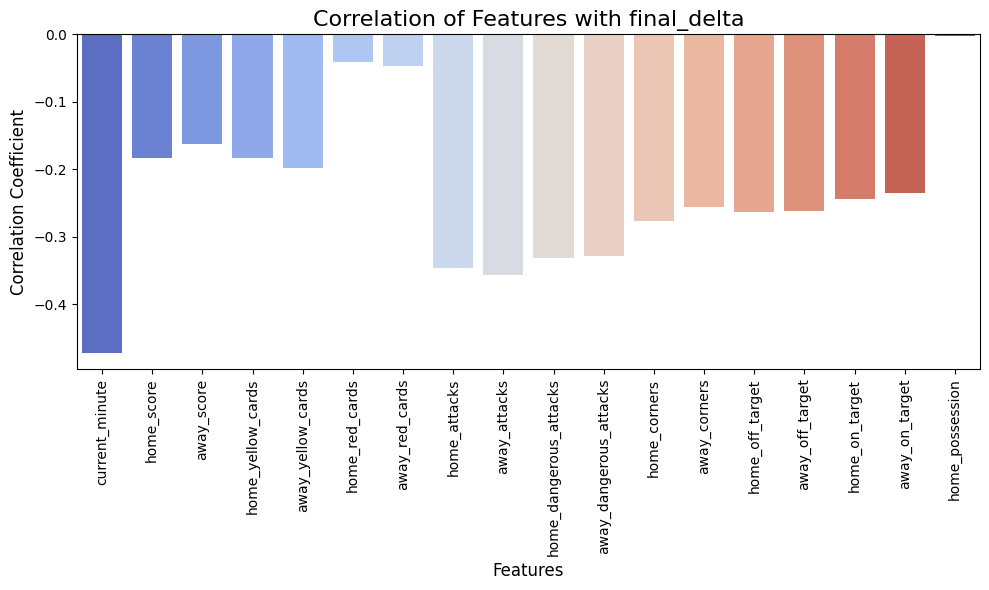

current_minute           -0.471751
home_score               -0.183846
away_score               -0.162591
home_yellow_cards        -0.183300
away_yellow_cards        -0.198380
home_red_cards           -0.041101
away_red_cards           -0.046158
home_attacks             -0.346235
away_attacks             -0.356338
home_dangerous_attacks   -0.331885
away_dangerous_attacks   -0.328005
home_corners             -0.276953
away_corners             -0.255762
home_off_target          -0.262712
away_off_target          -0.261091
home_on_target           -0.244178
away_on_target           -0.235565
home_possession          -0.002507
Name: final_delta, dtype: float64


In [13]:
# Calculate correlation of each feature with `final_delta`
correlations = df.corr()['final_delta'].drop('final_delta')

# Plot the correlation graph
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.index, y=correlations.values, palette='coolwarm')

# Add labels and titles

plt.xticks(rotation=90)
plt.title('Correlation of Features with final_delta', fontsize=16)
plt.ylabel('Correlation Coefficient', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.tight_layout()

# Show plot
plt.show()
print(correlations)


In [14]:
# Create a correlation matrix on numerical columns. Filter out the columns that are not numerical.
corr_matrix = df.select_dtypes(include=['int', 'float']).corr()
corr_matrix

,current_minute,home_score,away_score,home_yellow_cards,away_yellow_cards,home_red_cards,away_red_cards,home_attacks,away_attacks,home_dangerous_attacks,away_dangerous_attacks,home_corners,away_corners,home_off_target,away_off_target,home_on_target,away_on_target,home_possession,final_delta
current_minute,1.000000,0.386605,0.350519,0.303189,0.326720,0.071085,0.091855,0.615748,0.616063,0.589681,0.575603,0.488522,0.462596,0.507649,0.494418,0.488250,0.464476,-0.012020,-0.471751
home_score,0.386605,1.000000,0.126951,0.099390,0.135909,0.029943,0.066162,0.270429,0.247750,0.268536,0.204724,0.238969,0.178330,0.254369,0.187279,0.603209,0.175559,0.049724,-0.183846
away_score,0.350519,0.126951,1.000000,0.147570,0.103789,0.063829,-0.011946,0.213438,0.249274,0.199863,0.281989,0.152647,0.263376,0.164501,0.237653,0.158602,0.573068,-0.076239,-0.162591
home_yellow_cards,0.303189,0.099390,0.147570,1.000000,0.552962,0.039729,0.062943,0.278101,0.287941,0.262797,0.252712,0.199145,0.175638,0.203892,0.226635,0.156489,0.186023,-0.018854,-0.183300
away_yellow_cards,0.326720,0.135909,0.103789,0.552962,1.000000,0.053455,0.066983,0.313486,0.296088,0.308067,0.239991,0.258149,0.161998,0.262104,0.187004,0.202627,0.139745,0.046419,-0.198380
home_red_cards,0.071085,0.029943,0.063829,0.039729,0.053455,1.000000,0.096265,0.046435,0.055840,0.034671,0.059518,0.030856,0.048807,0.042132,0.063027,0.021419,0.060665,-0.021280,-0.041101
away_red_cards,0.091855,0.066162,-0.011946,0.062943,0.066983,0.096265,1.000000,0.073406,0.047761,0.088110,0.037962,0.086413,0.022058,0.094796,0.027313,0.065469,0.008986,0.045076,-0.046158
home_attacks,0.615748,0.270429,0.213438,0.278101,0.313486,0.046435,0.073406,1.000000,0.858770,0.902248,0.720579,0.583089,0.427367,0.639160,0.476116,0.537363,0.430920,0.176044,-0.346235
away_attacks,0.616063,0.247750,0.249274,0.287941,0.296088,0.055840,0.047761,0.858770,1.000000,0.752558,0.889661,0.454492,0.564320,0.510488,0.616124,0.458438,0.543357,-0.139416,-0.356338
home_dangerous_attacks,0.589681,0.268536,0.199863,0.262797,0.308067,0.034671,0.088110,0.902248,0.752558,1.000000,0.701464,0.670236,0.358458,0.661365,0.390859,0.554887,0.383643,0.225955,-0.331885


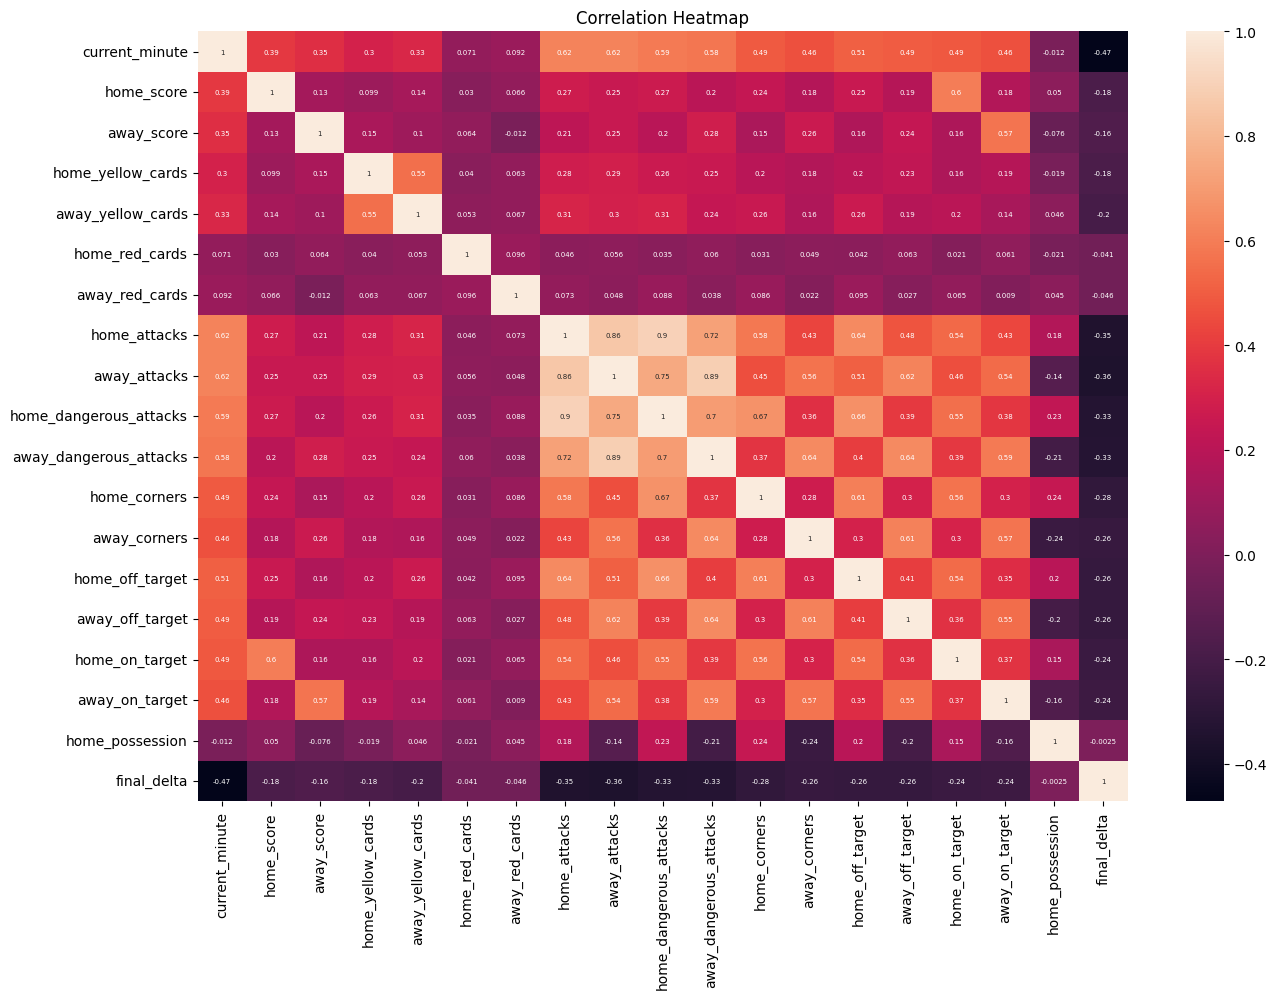

In [15]:
# Create a heatmap of the correlation matrix
fig, ax = plt.subplots(figsize=(15, 10))
plt.title('Correlation Heatmap')
sns.heatmap(corr_matrix, ax=ax, annot=True, annot_kws={'size': 5})
plt.show()

### Feature Engineering

In [16]:
df['home_attacks'] += 2 * df['home_dangerous_attacks']
df['away_attacks'] += 2 * df['away_dangerous_attacks']

df = df.drop(['home_dangerous_attacks', 'away_dangerous_attacks'], axis=1)
df

,current_minute,home_score,away_score,home_yellow_cards,away_yellow_cards,home_red_cards,away_red_cards,home_attacks,away_attacks,home_corners,away_corners,home_off_target,away_off_target,home_on_target,away_on_target,home_possession,final_delta
0,79,1,2,0,0,0,0,97,97,4,1,4,0,4,6,48,1
1,76,2,0,0,0,0,0,0,0,0,0,0,0,0,0,50,1
2,3,0,0,0,0,0,0,5,1,0,0,0,0,0,0,62,4
3,17,0,0,1,0,0,0,63,96,1,0,0,2,0,0,55,2
4,61,1,0,1,0,0,0,111,170,1,1,0,3,4,4,45,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6855,32,0,0,0,0,0,0,34,51,0,1,1,2,0,1,45,0
6856,86,3,0,0,1,0,0,0,0,0,0,0,0,0,0,50,0
6857,63,1,0,0,0,0,0,217,140,7,0,5,5,7,0,61,2
6858,57,2,0,0,0,0,0,177,106,3,0,4,1,2,1,52,0


In [17]:
df['home_attacks_per_minute'] = df['home_attacks'] / df['current_minute']
df['away_attacks_per_minute'] = df['away_attacks'] / df['current_minute']

df = df.drop(['home_attacks', 'away_attacks'], axis=1)

In [18]:
# Count total NaN values
nan_count = np.isnan(df).sum()
print(f"Total NaN values: {nan_count}")

Total NaN values: current_minute             0
home_score                 0
away_score                 0
home_yellow_cards          0
away_yellow_cards          0
home_red_cards             0
away_red_cards             0
home_corners               0
away_corners               0
home_off_target            0
away_off_target            0
home_on_target             0
away_on_target             0
home_possession            0
final_delta                0
home_attacks_per_minute    0
away_attacks_per_minute    0
dtype: int64


## **Section 5. Exploratory data analysis**

## **Section 6. Initial model training**

## Model Training

In [19]:
from sklearn.linear_model import Lasso
from utility import poly_feature_transform, compute_RMSE

In [20]:
X = df.drop('final_delta', axis=1)
y = df['final_delta']

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")


Shape of X: (6860, 16)
Shape of y: (6860,)


In [21]:
# Splitting data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3, 
                                                    random_state=42,
                                                    )


In [38]:
# Write your code here
lasso = Lasso(alpha = 0.0001 , max_iter = 100000,)

In [39]:
# Write your code here
order=3
poly_x = poly_feature_transform(X_train, order)

In [40]:
# Write your code here
lasso.fit(poly_x , y_train)

Lasso(alpha=0.0001, max_iter=100000)

### Training Error

In [41]:
# Write your code here
y_predicted = lasso.predict(poly_x)

y_predicted = np.floor(y_predicted)

In [42]:
# Write your code here
train_rmse = compute_RMSE(y_train , y_predicted)
print(f'Lasso (order={order}) train error: ' + '{:.4f}'.format(train_rmse))

Lasso (order=3) train error: 1.3380


In [43]:
summary = pd.DataFrame({
    'features': X_train.values.tolist(),  # Convert DataFrame to a list of lists
    'actual_label': y_train,
    'predicted_label': y_predicted
})


print(summary['actual_label'].unique())
summary['predicted_label'].unique()

[1 0 2 3 5 6 4 7 9 8]


array([ 1.,  2.,  0.,  3., -1.])

### Testing Error

In [44]:
# Write your code here
poly_test_x = poly_feature_transform(X_test,order)
y_predicted = lasso.predict (poly_test_x)

In [45]:
# Write your code here
test_rmse = compute_RMSE(y_test , y_predicted)
print(f'Lasso (order={order}) test error: ' + '{:.4f}'.format(test_rmse))

Lasso (order=3) test error: 1.2043


## **Section 7. Error analysis**